<a href="https://colab.research.google.com/github/efandresena/SemEval/blob/main/FastText_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subtask 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing and installing

In [3]:
!pip install gensim

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import numpy as np
from gensim.utils import simple_preprocess

import torch
from torch.utils.data import Dataset, DataLoader


In [4]:
# Change working directory
wokdir = "/content/drive/MyDrive/NLP/SemEval"

In [35]:
CONFIG = {
    'language': 'eng',
    'data_subfolder': "dev_phase/subtask1/",
    'save_as_prefix': "pred_"
}

In [36]:
current_language = CONFIG['language']
base_dir_relative_path = CONFIG['data_subfolder']

train_file_relative = os.path.join(base_dir_relative_path, f"train/{current_language}.csv")
dev_file_relative = os.path.join(base_dir_relative_path, f"dev/{current_language}.csv")

train_path = os.path.join(wokdir, train_file_relative)
dev_path = os.path.join(wokdir, dev_file_relative)

train_pd = pd.read_csv(train_path)
dev_pd = pd.read_csv(dev_path)
train_pd.head()

,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0


### Exploratory data analysis

/tmp/ipython-input-1882752345.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


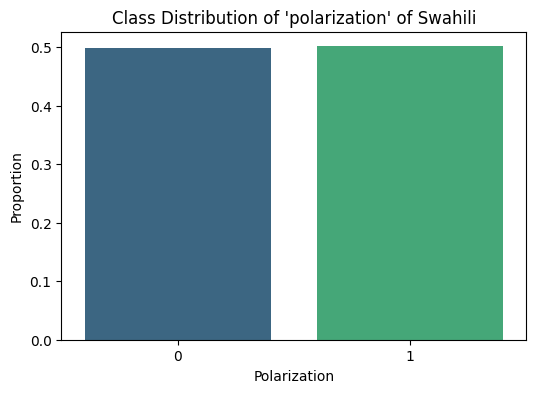

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count and normalize
class_counts = train_pd['polarization'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution of 'polarization' of Swahili")
plt.ylabel("Proportion")
plt.xlabel("Polarization")
plt.savefig("class_distribution_swa.pdf")
plt.show()

In [37]:
counts = train_pd['polarization'].value_counts(normalize=True)

p0 = counts[0]   # 0.244298
p1 = counts[1]   # 0.755702

w0 = 1 / p0
w1 = 1 / p1

class_weights = torch.tensor([w0, w1], dtype=torch.float32)
class_weights


tensor([1.5740, 2.7421])

## Embeddings Fasttext

In [38]:
from gensim.models import FastText

In [39]:
# text processing : Tokenize
text_list = train_pd['text'].to_list()
sentences = [sentence.split() for sentence in text_list]

In [40]:
# Embedding fastText using skipgram
fasttext_sg = FastText(
    sentences = sentences,
    vector_size = 300,
    window=5,
    min_count=1,
    sg=1,
    min_n=2,
    max_n=5,
    epochs=100,
    seed=42
)
print(f"Vector size: {fasttext_sg.vector_size}")

Vector size: 300


In [41]:
# Embedding fastText using cbow
fasttext_cbow = FastText(
    sentences = sentences,
    vector_size = 300,
    window=5,
    min_count=1,
    sg=0,
    min_n=2,
    max_n=5,
    epochs=100,
    seed=42
)
print(f"Vector size: {fasttext_cbow.vector_size}")

Vector size: 300


In [42]:
def sentence_vector(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)


processed_sentences = [simple_preprocess(s) for s in train_pd['text'].to_list()]

# Generate sentence vectors for each model
cbow_sentence_embeddings = np.array([sentence_vector(s, fasttext_cbow) for s in processed_sentences])
sg_sentence_embeddings = np.array([sentence_vector(s, fasttext_sg) for s in processed_sentences])

# Concatenate the sentence embeddings for each sentence
phrase_vector = np.concatenate([cbow_sentence_embeddings, sg_sentence_embeddings], axis=1)

print(f"Shape of combined phrase_vector: {phrase_vector.shape}")

Shape of combined phrase_vector: (3222, 600)


In [43]:
X = phrase_vector                           # shape (3332, 600)
y = train_pd['polarization'].values                # your label column (0/1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.05, random_state=42, stratify=y
)

In [44]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)


In [45]:
class PhraseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PhraseDataset(X_train_tensor, y_train_tensor)
val_dataset   = PhraseDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [46]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(600, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)


In [47]:
model = Classifier()
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# class weights computed earlier
class_weights = {0: w0, 1: w1}

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)

        # BCE loss per sample (not averaged)
        losses = criterion(outputs, y_batch)

        # select weight for each sample in the batch
        batch_weights = torch.tensor(
            [class_weights[int(y.item())] for y in y_batch],
            dtype=torch.float32
        ).unsqueeze(1)

        # apply weights
        loss = (losses * batch_weights).mean()

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)

            # normal (non-weighted) loss for validation
            loss = criterion(outputs, y_batch).mean()
            val_loss += loss.item()

            preds = (outputs > 0.45).float()
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {correct/total:.4f}")


Epoch 1 | Train Loss: 129.6593 | Val Loss: 4.2125 | Val Acc: 0.6975
Epoch 2 | Train Loss: 125.3535 | Val Loss: 4.2278 | Val Acc: 0.6914
Epoch 3 | Train Loss: 125.3561 | Val Loss: 4.1770 | Val Acc: 0.7037
Epoch 4 | Train Loss: 124.5290 | Val Loss: 4.1470 | Val Acc: 0.7037
Epoch 5 | Train Loss: 123.6359 | Val Loss: 4.2037 | Val Acc: 0.6975
Epoch 6 | Train Loss: 123.1435 | Val Loss: 4.0817 | Val Acc: 0.7160
Epoch 7 | Train Loss: 122.2299 | Val Loss: 4.1108 | Val Acc: 0.7284
Epoch 8 | Train Loss: 121.2589 | Val Loss: 4.1731 | Val Acc: 0.7222
Epoch 9 | Train Loss: 121.9045 | Val Loss: 4.1608 | Val Acc: 0.7407
Epoch 10 | Train Loss: 120.7021 | Val Loss: 4.0329 | Val Acc: 0.7531


In [48]:
# Preprocess
X_dev_tokens = [simple_preprocess(s) for s in dev_pd['text']]

# Embed with CBOW + SG
cbow_dev_embeddings = np.array([sentence_vector(tokens, fasttext_cbow) for tokens in X_dev_tokens])
sg_dev_embeddings   = np.array([sentence_vector(tokens, fasttext_sg) for tokens in X_dev_tokens])

# Concatenate
X_dev_concat = np.concatenate([cbow_dev_embeddings, sg_dev_embeddings], axis=1)

# Convert to tensor
X_dev_tensor = torch.tensor(X_dev_concat, dtype=torch.float32)

In [49]:
model.eval()  # set to evaluation mode

with torch.no_grad():
    outputs = model(X_dev_tensor)           # shape: (num_dev_samples, 1)
    predictions = (outputs > 0.5).float()  # convert probabilities to 0/1

In [50]:
y_pred = [int(p) for p in predictions.squeeze().tolist()]
dev_pd['polarization'] = y_pred

# Construct the output filename using CONFIG
output_filename = f"{CONFIG['save_as_prefix']}{CONFIG['language']}.csv"

dev_pd.drop(columns=['text'], inplace=True)
dev_pd.to_csv(output_filename, index=False)
dev_pd.head()

,id,polarization
0,eng_f66ca14d60851371f9720aaf4ccd9b58,1
1,eng_3a489aa7fed9726aa8d3d4fe74c57efb,0
2,eng_95770ff547ea5e48b0be00f385986483,0
3,eng_2048ae6f9aa261c48e6d777bcc5b38bf,0
4,eng_07781aa88e61e7c0a996abd1e5ea3a20,1


In [51]:
# free space
import gc
del X_train, X_val, X_dev_concat, cbow_sentence_embeddings, sg_sentence_embeddings
del X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_dev_tensor
del train_dataset, val_dataset, train_loader, val_loader
gc.collect()

88